# Discover sentiment in tweets

Sentiment analysis is commonly used in marketing and customer service to answer questions such as "Is a product review positive or negative?" and "How are customers responding to a product release?"

*Topic modeling* discovers the abstract topics in a corpus of texts. The results from topic modeling analysis can then be used in sentiment analysis. For example, they can be used to split texts into different subsets and allow us to train a separate sentiment model for each of the subsets. Training separate sentiment models for different subsets can lead to more accurate predictions than using a single model for all the texts. 

This notebook illustrates how to discover and visualize topics from a corpus of Twitter tweets using Jupyter notebook. 

## Read and prepare the data

The dataset used in this notebook is based on the [Sentiment140](http://help.sentiment140.com/) dataset, which contains approximately 1,600,000 automatically annotated tweets with six fields per tweet. Here we use only a [160,000 tweet sample](http://azuremlsamples.azureml.net/templatedata/Text%20-%20Input.csv) of that dataset with two fields for each tweet: the polarity of the tweet and the text of the tweet.

The following command downloads the data into the file *sentiment140-subset.csv* in the current session.

In [13]:
!curl -o sentiment140-subset.csv http://azuremlsamples.azureml.net/templatedata/Text%20-%20Input.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 15 11.8M   15 1890k    0     0  3573k      0  0:00:03 --:--:--  0:00:03 3567k
 75 11.8M   75 9172k    0     0  5987k      0  0:00:02  0:00:01  0:00:01 5983k
100 11.8M  100 11.8M    0     0  6536k      0  0:00:01  0:00:01 --:--:-- 6533k


You can use the `ls` command to see it in the project's files:

In [14]:
!ls

3D Objects
Allzephyr - Copy.xlsx
Allzephyr.xlsx
Anaconda3
Anaconda3-2019.10-Windows-x86_64.exe
AppData
Application Data
Applications
ArcGIS
Contacts
Cookies
Desktop
Discover Sentiments in Tweets.ipynb
Documents
Downloads
Dropbox
Favorites
Git-2.23.0-64-bit.exe
Group_Project_1-2.ipynb
Group_Project_week12.ipynb
HP
Indicators.csv
Intel
IntelGraphicsProfiles
Links
Local Settings
Microsoft
MicrosoftEdgeBackups
Music
My Documents
NTUSER.DAT
NTUSER.DAT{fd9a35db-49fe-11e9-aa2c-248a07783950}.TM.blf
NTUSER.DAT{fd9a35db-49fe-11e9-aa2c-248a07783950}.TMContainer00000000000000000001.regtrans-ms
NTUSER.DAT{fd9a35db-49fe-11e9-aa2c-248a07783950}.TMContainer00000000000000000002.regtrans-ms
NetHood
NishthaDuttaCodingChallenge.ipynb
OneDrive
Pictures
PrintHood
Recent
Roaming
SQLServer2017-SSEI-Dev.exe
SSMS-Setup-ENU-Upgrade.exe
SSMS-Setup-ENU.exe
Saved Games
Searches
SendTo
Start Menu
Templates
Untitled.ipynb
Untitled1.ipynb
Untitled10.ipynb
Untitled11.ipynb
Untitled12.ipynb
Untitled13.ipynb
Untitled14.i

Next, prepare the data.

In [29]:
import os
import pandas as pd

dirname = os.getcwd()
print(dirname)

mydata = pd.read_csv("sentiment140-subset.csv", header = 0)
print(mydata.shape)

# Use 10000 for testing
mydata = mydata[:10000] 
mydata.head()

C:\Users\nishtha
(160000, 2)


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Before doing analysis, clean up the text by removing the Twitter handle, removing numbers and consecutive underscores, and changing to lower case:

In [30]:
import re

def clean_text(string_in):
    string_in = re.sub(r"@\w+", "", string_in) # Remove twitter handle
    string_in = re.sub(r"\d", "", string_in)   # Remove numbers  
    string_in = re.sub(r"_+", "", string_in)   # Remove consecutive underscores
    string_in = string_in.lower()              # Tranform to lower case    
    
    return string_in.strip()

mydata["tweet_text_cleaned"] = mydata.tweet_text.apply(clean_text)
print(mydata["tweet_text_cleaned"])

0       hey dear, happy friday to you  already had you...
1       ughhh layin downnnn    waiting for zeina to co...
2       i reckon he'll play, even if he's not %...but ...
3                            i know!  saw it on the news!
4       very sad that http://www.fabchannel.com/ has c...
                              ...                        
9995    lol ill be back. when yall learn how to use a ...
9996    i wasn't  i was with the bf at the time, and a...
9997                                            thanks  x
9998                             going work...i feel cold
9999                                    eatinqq popcorn !
Name: tweet_text_cleaned, Length: 10000, dtype: object


Now tokenize the text data using the following line of code:

In [31]:
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]
print(preprocessed)

['hey dear happy friday to you already had your rice s bowl for lunch', 'ughhh layin downnnn waiting for zeina to cook breakfast', 'i reckon he ll play even if he s not but i know nothing it won t be the same without him', 'i know saw it on the news', 'very sad that http www fabchannel com has closed down one of the few web services that i ve used for over years', 'who sings i remember i alwaysss hear it on radio but never catch the artist', 'with god on ur side anything is possible', 'why being stupid', 'having delved back into the guts of expression engine its a flexible cms if you have to use it as a dev not great for clients though', 'awww take him with you', 'the video on vh is much better than the u tube one', 'i ran out of champagne i wonder if i call my brother i could convince him to bring me up a bottle', 'i wish i was going to the show tonight', 'doing homework then bed waking up at is gonna be awful', 'ashleyltmsyf hey ashley when will the hush hush hush hush video be out c

## Identify topics

### Calculate tf-idf matrix

In order to use non-negative matrix factorization, we first calculate the *tf-idf* (term frequency-inverse document frequency) matrix. The value of tf-idf reflects the number times a word appears in the *document* after adjusting for the frequency of the word in the *corpus*.

When calculating the tf-idf matrix, we can filter out words like "being" and "for" which are called *stop words*. The following code filters out the stop words as defined by the [scikit-learn](http://scikit-learn.org/stable/) package. You can expand the list of stop words by adding to the `custom_stop_words` variable. 

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

custom_stop_words = ["being", "for"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size %d x %d" % (tfidf.shape[0],tfidf.shape[1]))
print(tfidf)

Created document-term matrix of size 10000 x 13379
  (0, 6898)	0.33793047336148796
  (0, 1371)	0.48029634268118193
  (0, 9666)	0.44747321689772623
  (0, 4347)	0.3551708501054696
  (0, 5045)	0.28572571469808344
  (0, 2832)	0.3904222672812511
  (0, 5196)	0.30768665058230316
  (1, 1419)	0.3109436388204976
  (1, 2418)	0.34740122500958454
  (1, 13298)	0.43245349548141554
  (1, 12602)	0.2764175574336564
  (1, 3278)	0.43245349548141554
  (1, 6513)	0.41402968528006706
  (1, 12192)	0.40095778391249426
  (2, 12959)	0.39384642413704063
  (2, 6334)	0.30834765402611164
  (2, 8735)	0.44462052426894566
  (2, 6732)	0.32639429223253763
  (2, 9406)	0.6675223395871395
  (3, 7819)	0.649687614617226
  (3, 9986)	0.6144895751935414
  (3, 6334)	0.447558449134233
  (4, 13180)	0.2914535521665897
  (4, 12354)	0.29770926046332596
  (4, 12422)	0.22688431497858141
  :	:
  (9993, 12959)	0.14819421880671046
  (9994, 5954)	0.8526517846037194
  (9994, 12636)	0.5224796017186627
  (9995, 13143)	0.3543641631692515
  (9995

### NMF analysis

If we use **X** to represent a **document-word** matrix with tf-idf values, non-negative matrix factorization factorizes the matrix into two matrices **W** and **H**, representing **document-topic** and **topic-word** matrices, respectively, as shown in the following figure:

![Figure 1](https://cloud.githubusercontent.com/assets/9322661/18445719/ea601214-78ec-11e6-9858-b29d62e29c9e.png)

The matrix **W** allows us to compare texts and determine which ones are similar. The matrix **H** tells us the top words in any given topic and we can use visualization to better undertand the topics. 

For any new text represented by **X_new**, we can make predictions in the sense that the **W_new** value can be computed from the **H** matrix.

Other topic finding models (e.g., Latent Dirichlet Allocation (LDA)) are also available in the [scikit-learn](http://scikit-learn.org/stable/) package but aren't covered here. Compared with LDA, NMF has cheaper computation cost and is a good choice for short text analysis.  

Now we can use NMF on the derived tf-idf matrix. We specify the number of topics to be three. 

In [21]:
from sklearn import decomposition
import numpy as np
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W = nmf.fit_transform(tfidf)
H = nmf.components_
print("Generated factor W of size %s and factor H of size %s" % ( str(W.shape), str(H.shape)))

feature_names = vectorizer.get_feature_names()
n_top_words = 10

# Print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Generated factor W of size (10000, 3) and factor H of size (3, 13379)
Topic #0:
good day work just today morning going like night really

Topic #1:
quot love http just com know amp new like best

Topic #2:
thanks following ff lol got haha great hey hope follow



## Visualize topics with a word cloud

To better communicate the topics found, we can use the [wordcloud](https://github.com/amueller/word_cloud) package. Because this package is not pre-installed, install it first using commands:

In [22]:
!pip install wordcloud

Next, separate the topics into separate sorted lists:

In [34]:
# Create pandas dataframe for the topics
mydf = pd.DataFrame({"feature_name": feature_names})

for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []

for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

mywords_topic1 = sorted(mywords_topic1, key=lambda myword: myword[1], reverse=True)
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: myword[1], reverse=True)
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: myword[1], reverse=True)
print(mywords_topic1)

[('good', 1.4421587096945558), ('day', 0.9751500086498209), ('work', 0.9239126457433102), ('just', 0.6122341723172006), ('today', 0.5960541861647171), ('morning', 0.497089065076388), ('going', 0.4961500639980171), ('like', 0.4264899079942007), ('night', 0.4184057005994652), ('really', 0.4180567012940522), ('know', 0.41288734119449305), ('don', 0.3873805598564069), ('got', 0.3859867290953106), ('love', 0.38076097511321666), ('time', 0.375531604781233), ('sleep', 0.3404401341033703), ('lol', 0.3396389599013938), ('hope', 0.3131828252866481), ('im', 0.3102110005438915), ('home', 0.2785991960203683), ('feel', 0.2736467169500906), ('tomorrow', 0.27124290896236536), ('oh', 0.26562709371201176), ('want', 0.2582314455979453), ('great', 0.2502110234859665), ('ll', 0.23821279172227738), ('bed', 0.23761149584954297), ('think', 0.23745962431346115), ('miss', 0.2267130605993359), ('fun', 0.218123093375398), ('twitter', 0.2154035830616517), ('happy', 0.2101144462911897), ('new', 0.20787366675057267)

Finally, generate the word cloud for the three topics identified from NMF. Larger fonts indicate higher weights of the words in a topic and the colors are randomly assigned. Compared with a simple list, from a word cloud we can better understand the relative frequency of all the words:

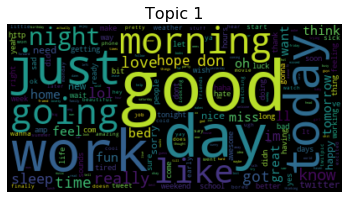

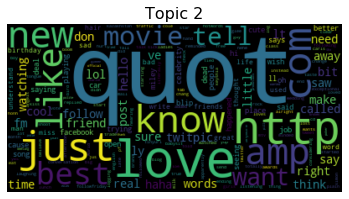

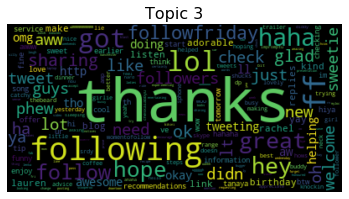

In [24]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

%matplotlib inline

def draw_wordcloud(dict, topic_number):
    wc = WordCloud(max_words=1000)    
    wordcloud = WordCloud().generate_from_frequencies(dict)
    
    plt.title('Topic %s' %str(topic_number), size = 16)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")        
    plt.show()

draw_wordcloud(dict(mywords_topic1), topic_number=1)
draw_wordcloud(dict(mywords_topic2), topic_number=2)
draw_wordcloud(dict(mywords_topic3), topic_number=3)

## Making predictions

For any new tweet, we first calculate its tf-idf matrix (**X**) and then calculate its **W** matrix. This will then allow us to assign the new tweet to a segment and predict its sentiment (for example, positive sentiment vs. negative sentiment on a product).

The following code shows how to calcuate the **W** matrix for new tweets that have been cleaned beforehand. For illustration purpose, these five tweets are the first five from the corpus used in the analysis.  

In [37]:
# Prediction example
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
W_new = nmf.transform(tfidf_new)
print(text_new)
print(W_new)

['hey dear happy friday to you already had your rice s bowl for lunch', 'ughhh layin downnnn waiting for zeina to cook breakfast', 'i reckon he ll play even if he s not but i know nothing it won t be the same without him', 'i know saw it on the news', 'very sad that http www fabchannel com has closed down one of the few web services that i ve used for over years']
[[0.01436616 0.00102548 0.0039611 ]
 [0.00263201 0.00048883 0.        ]
 [0.02593642 0.0042968  0.00012123]
 [0.02484761 0.00870283 0.00070148]
 [0.01683759 0.01022057 0.00027782]]




Copyright (C) Microsoft. All Rights Reserved.